## Assignment 3:

The goal is to compare several NLP algorithms for Reuters data – multi-class classification problem
 
First, do EDA to understand how many topics (classes) are there in the data. Also understand how many documents
are there in each class. You may want to reduce the number of topics to top 10 or something like that, based
on frequencies.  

In all the experiments, we would hold some parameters constants – truncation of the documents to 10,000 tokens,
 the batch size to 100, the number of epochs to 10, same optimizer, same loss function of cross entropy, so that
 the comparisons are fair.
 
* EXPERIMENT 1: Fully connected dense neural network
* **EXPERIMENT 2: Simple RNN**
* EXPERIMENT 3: LSTM RNN
* EXPERIMENT 4: 1D CNN

`Result`:  Create a table with the accuracy and loss for train/test/validation & process time for all the 4 models.

`Note`: You can tweak several parameters such as dropout, embedding etc. to get more insights.

In [1]:
import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.2.4-tf'

## The Reuters dataset

We will be working with the `Reuters dataset`, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

Like MNIST and Fashion MNIST, the Reuters dataset comes packaged as part of Keras. 

See https://keras.io/api/datasets/reuters/#load_data-function


"Each newswire is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words"."

In [2]:
# https://keras.io/datasets/#reuters-newswire-topics-classification
from tensorflow.keras.datasets import reuters

voc_size = 10000

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=voc_size)

The argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the data.

We have 8,982 training examples and 2,246 test examples:

## Reducing the number of topics

In [3]:
from collections import Counter
topics_train_tpl, _ = zip(*Counter(list(train_labels)).most_common(9))
topics_train_tpl

(3, 4, 19, 16, 1, 11, 20, 13, 8)

In [4]:
topics_test_tpl, _ = zip(*Counter(list(test_labels)).most_common(9))
topics_test_tpl

(3, 4, 19, 1, 16, 11, 20, 8, 13)

In [5]:
train_data_sm, train_labels_sm = zip(*((x,y) for x,y in zip(train_data,train_labels) if y in topics_train_tpl))

In [6]:
import numpy as np
train_data_sm, train_labels_sm = np.array(train_data_sm), np.array(train_labels_sm)

In [7]:
len(train_data_sm), len(train_labels_sm)  # matches number of training values in top 10

(7503, 7503)

In [8]:
test_data_sm, test_labels_sm = zip(*((x,y) for x,y in zip(test_data,test_labels) if y in topics_test_tpl))

In [9]:
test_data_sm, test_labels_sm = np.array(test_data_sm), np.array(test_labels_sm)

In [10]:
len(test_data_sm), len(test_labels_sm) # matches number of test values in top 10

(1852, 1852)

In [11]:
Counter(train_labels_sm) # another sanity check on the the new smaller set of training labels. See In [13].

Counter({3: 3159,
         4: 1949,
         16: 444,
         19: 549,
         8: 139,
         11: 390,
         1: 432,
         13: 172,
         20: 269})

In [12]:
Counter(test_labels_sm) # another sanity check on the the new smaller set of test labels. See In [14].

Counter({3: 813,
         1: 105,
         4: 474,
         11: 83,
         19: 133,
         8: 38,
         20: 70,
         16: 99,
         13: 37})

# EXPERIMENT  2 : Simple RNN.

In [13]:
import numpy as np
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## Preparing the data

We need to vectorize the sequence into numeric tensors that the neural networks can work with.

In [14]:
train_data_sm.shape, test_data_sm.shape

((7503,), (1852,))

In [15]:
# import numpy as np

# def vectorize_sequences(sequences, dimension=10000):
#     results = np.zeros((len(sequences), dimension))
#     for i, sequence in enumerate(sequences):
#         results[i, sequence] = 1.
#     return results

# # Our vectorized training data
# train_data_smv = vectorize_sequences(train_data_sm)
# # Our vectorized test data
# test_data_smv = vectorize_sequences(test_data_sm)

In [16]:
# Alternate processing for RNN...
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb

from tensorflow.keras import preprocessing


train_data_sm_rnn = preprocessing.sequence.pad_sequences(train_data_sm, maxlen=193)
test_data_sm_rnn = preprocessing.sequence.pad_sequences(test_data_sm, maxlen=193)

In [17]:
from tensorflow.keras.utils import to_categorical

one_hot_train_labels_sm = to_categorical(train_labels_sm)
one_hot_test_labels_sm = to_categorical(test_labels_sm)

In [18]:
train_labels_sm.shape, one_hot_train_labels_sm.shape

((7503,), (7503, 21))

In [19]:
test_data_sm_rnn.shape, train_data_sm_rnn.shape, one_hot_train_labels_sm.shape, one_hot_test_labels_sm.shape

((1852, 193), (7503, 193), (7503, 21), (1852, 21))

## Building our network

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(voc_size, 128, input_length = 193))
model.add(SimpleRNN(64))
model.add(Dense(21, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 128)          1280000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                12352     
_________________________________________________________________
dense (Dense)                (None, 21)                1365      
Total params: 1,293,717
Trainable params: 1,293,717
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

In the commented code below we set apart 1,000 samples in our training data to use as a validation set. Instead, we set the validation_split (=0.15) when training the model.As an alternative, you can uncomment this code and uncomment: validation_data=(val_data_smv, one_hot_val_labels_sm)).

In [22]:
# val_data_sm_rnn = train_data_sm_rnn[:1000]
# train_data_sm_rnn = train_data_sm_rnn[1000:]

# one_hot_val_labels_sm = one_hot_train_labels_sm[:1000]
# one_hot_train_labels_sm = one_hot_train_labels_sm[1000:]

In [23]:
# test_data_sm_rnn.shape, train_data_sm_rnn.shape, one_hot_train_labels_sm.shape, one_hot_test_labels_sm.shape

## Training the model

To get the total training time I used the callback. 

In [24]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

Now let's train our network for 10 epochs:

In [25]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_data_sm_rnn,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                   validation_data=(val_data_sm_rnn, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 5s 836us/sample - loss: 1.7559 - accuracy: 0.4737 - val_loss: 1.3804 - val_accuracy: 0.5746
Epoch 2/10
6377/6377 [==============================] - 5s 724us/sample - loss: 1.2065 - accuracy: 0.6139 - val_loss: 1.2920 - val_accuracy: 0.5888
Epoch 3/10
6377/6377 [==============================] - 4s 705us/sample - loss: 0.9088 - accuracy: 0.7093 - val_loss: 1.1983 - val_accuracy: 0.6083
Epoch 4/10
6377/6377 [==============================] - 5s 715us/sample - loss: 0.6218 - accuracy: 0.8397 - val_loss: 1.1722 - val_accuracy: 0.6403
Epoch 5/10
6377/6377 [==============================] - 5s 710us/sample - loss: 0.4041 - accuracy: 0.9134 - val_loss: 1.2529 - val_accuracy: 0.6243
Epoch 6/10
6377/6377 [==============================] - 4s 695us/sample - loss: 0.2665 - accuracy: 0.9476 - val_loss: 1.3760 - val_accuracy: 0.5950
Epoch 7/10
6377/6377 [==============================] - 5s 725us

In [26]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

46.123919

## Testing the model

Test the model and get its runtime using callbacks.

In [27]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [28]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt])

1852/1852 [==============================] - 1s 291us/sample - loss: 1.4640 - accuracy: 0.5961


In [29]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.539336

In [30]:
history_dict = history.history.copy()
history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_dict.keys()

dict_keys(['loss', 'val_loss', 'val_accuracy', 'train_accuracy'])

In [31]:
import pandas as pd
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,val_loss,val_accuracy,train_accuracy
5,0.266495,1.375968,0.595027,0.947624
6,0.186960,1.319404,0.618117,0.960953
7,0.143498,1.461789,0.606572,0.963619
8,0.124699,1.412296,0.640320,0.965501
9,0.108571,1.551181,0.588810,0.966599


## Saving the performance to a DataFrame

Let us now create the DataFrame with statistics which we append to the DataFrame from part 1. Note that we only need the last row of history_df.

In [32]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','Simple RNN') # went the model name to appear first
results_df['test_accuracy'] = test_accuracy
results_df['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df

,model,loss,val_loss,val_accuracy,train_accuracy,test_accuracy,training time (sec),testing time (sec)
9,Simple RNN,0.108571,1.551181,0.58881,0.966599,0.596112,46.123919,0.539336


In [33]:
prev_results_df = pd.read_pickle('results1.pkl')
results_df = prev_results_df.append(results_df,ignore_index=True)
results_df

,model,loss,val_loss,val_accuracy,train_accuracy,test_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.095976,0.759006,0.852575,0.968480,0.785396,7.403748,0.199387
1,DNN (2 layers) w Drop,0.101209,0.732633,0.865672,0.969255,0.864471,7.406006,0.154858
2,DNN (2 layers) w Embed,0.050186,1.056904,0.793073,0.971303,0.804536,17.530022,0.222688
3,DNN (2 layers) w Embed + Dropout,0.073270,0.986761,0.820604,0.969265,0.819654,17.820075,0.187404
4,Simple RNN,0.108571,1.551181,0.588810,0.966599,0.596112,46.123919,0.539336


## Plotting the performance 

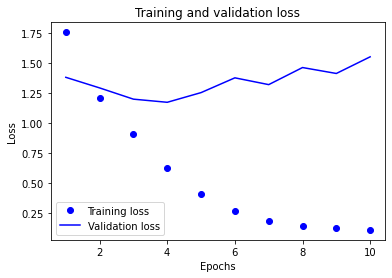

In [34]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

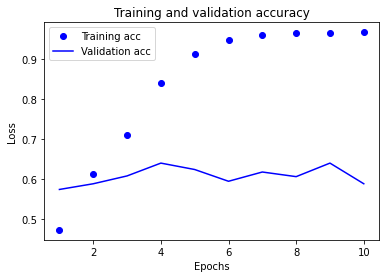

In [35]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Our approach reaches an accuracy of ~96%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%, but in our case it is closer to 28%, so our results seem pretty good, at least when compared to a random baseline:

In [36]:
import copy

test_labels_sm_copy = copy.copy(test_labels_sm)
np.random.shuffle(test_labels_sm_copy)
float(np.sum(np.array(test_labels_sm) == np.array(test_labels_sm_copy))) / len(test_labels_sm)

0.2818574514038877

## Saving to a DataFrame to disk

Save the DataFrame for use in part 3.

In [37]:
results_df.to_pickle("results2.pkl") 